<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC3
</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Recurrent Neural Networks

En esta práctica implementaremos redes neuronales recurrentes para generar música.

**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio. Para exportar el notebook a html puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

# 0. Contexto y referencias

Esta PEC está basada en el siguiente [artículo de investigación](https://arxiv.org/pdf/1711.07682.pdf), aunque por motivos de extensión no podremos pasar por todos los puntos del artículo.

La primera etapa de esta PEC será leer y entender la idea general de este trabajo. El artículo os da acceso al código original con el que se ha llevado a cabo el trabajo y en el que además esta basado gran parte del código que aquí os adjuntamos, aunque por la complejidad y extensión del código no os recomendamos que sumergáis demasiado en él.

La PEC consta de una etapa de ***interpretación de los datos*** (un paso vital en todo proyecto real), donde se pedirá reproducir una gráfica del artículo. Luego ***entrenaremos*** una red LSTM para generar acordes a partir de archivos MIDI. Finalmente, usaremos la capa de ***embedding*** de la red entrenada para hacer una proyección de los acordes en 2D y visualizar el concepto de [word2vec](https://en.wikipedia.org/wiki/Word2vec).

Además de este fichero os hemos adjuntado un archivo comprimido con una estructura de datos similar a la usada en el artículo y que os recomendamos (por vuestro bien) que no modifiquéis :). Allí encontraréis una carpeta llamada *data* donde se encuentra la base de datos que usaremos y otros ficheros que os facilitamos con datos de redes ya entrenadas (en la carpeta *models*)

# 1. Procesado de datos [2.5 pts]

## 1.1 Importación de módulos y paquetes necesarios

In [1]:
!pip install pretty_midi==0.2.8

     |████████████████████████████████| 5.6 MB 4.6 MB/s 
     |████████████████████████████████| 51 kB 4.1 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.8-py3-none-any.whl size=5590821 sha256=44c85daea020b479f688a939e5bb101f9c92504e99776d43b913ce7ba91393ea
  Stored in directory: /root/.cache/pip/wheels/53/fd/dd/20e1b16dbcf028bbbd7f53b570bc3521183731cba4a73cb310
Successfully built pretty-midi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# añade el path a tu directorio
%cd /content/drive/My Drive/deep_learning/PEC3_PAC3

/content/drive/My Drive/deep_learning/PEC3_PAC3


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
import os
import sys
import pretty_midi as pm
import mido
from collections import Counter
import collections
import pandas as pd

importamos módulos propios (archivos .py) que podréis encontrar en la estructura de carpetas que os hemos facilitado

In [5]:
from settings import *
import midi_functions as mf 
import data_processing_functions as dpf

## 1.2 Ficheros MIDI [1 pt]

En esta sección vamos a entender un poco mejor la información que contiene un fichero MIDI y reproduciremos un archivo de nuestra base de datos. Para esta sección os recomendamos que le echéis un vistazo a la sección "*Extract notes*" del siguiente [tutorial de tensorflow](https://www.tensorflow.org/tutorials/audio/music_generation).

1.2.1 Escoger un fichero MIDI de la base de datos y crear las funciones necesarias para extraer las notas, el tiempo en que se toca cada nota, su duración y el momento en que se tocan. Este proceso se debe aplicar solo a un instrumento: **"Acoustic Grand Piano"**. 

*nota: Si el fichero escogido no tiene piano elegir otro fichero*

In [6]:
import glob

In [7]:
FILE_PATH = './data/original/'
PIANO_PROGRAM_NAME = 'Acoustic Grand Piano'
# Get the 'Acoustic Grand Piano' program int value from INSTRUMENT_MAP constant
PIANO_PROGRAM = pm.constants.INSTRUMENT_MAP.index(PIANO_PROGRAM_NAME)

def search_midi_with_piano(file_path: str):
  """Searches a midi file that contains 'Acoustic Grand Piano' instrument.
  NOTE: It is known that the directory contains several files that 
  match the criteria

  Returns
  -------
  midi : PrettyMidi
          MIDI file object found.
  """
  filenames = glob.glob(file_path + '*.mid*')
  print('Number of files:', len(filenames))

  for file in filenames:
    print('Checking file:' + file)
    midi = pm.PrettyMIDI(file)    
    if has_program(midi, PIANO_PROGRAM):
      print('Selected file:' + file)
      return midi

def has_program(midi: pm.PrettyMIDI, program: int):
  """Checks whether if the program is in the list of MIDI instruments
  """
  for i in midi.instruments:
    if i.program == program:
      return True
  return False


def get_instrument(midi: pm.PrettyMIDI, program: int):
  """Returns the instrument with the specified program in a MIDI file

  Returns
  -------
  instrument : Instrument
          Instrument with the specified program.
  """
  for i in midi.instruments:
    if i.program == program:
      return i
  raise(Exception('Program not found'))

midi = search_midi_with_piano(FILE_PATH)
piano = get_instrument(midi, PIANO_PROGRAM)

Number of files: 49
Checking file:./data/original/5dd29e99ed7bd3cc0c5177a6e9de22ea.mid
Selected file:./data/original/5dd29e99ed7bd3cc0c5177a6e9de22ea.mid


In [8]:
def midi_to_notes(instrument: pm.Instrument) -> pd.DataFrame:
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['tono'].append(note.pitch)
    notes['inicio'].append(start)
    notes['fin'].append(end)
    notes['momento'].append(start - prev_start)
    notes['duracion'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(piano)
raw_notes.head()


,tono,inicio,fin,momento,duracion
0,65,1.983468,2.063013,0.000000,0.079545
1,69,1.983468,2.063013,0.000000,0.079545
2,35,1.983468,2.072311,0.000000,0.088843
3,35,2.148757,2.233468,0.165289,0.084711
4,69,2.148757,2.234501,0.000000,0.085744


1.2.2 Modificar la funcion *plot_piano_roll* del tutorial para poder graficar el pianoroll de la canción MIDI escogida. En este caso deberemos poder indicar un tiempo máximo de la canción que queremos añadir en el pianoroll. Además, si pasamos un *max_time=-1*, se deberán graficar todas las notas de la canción

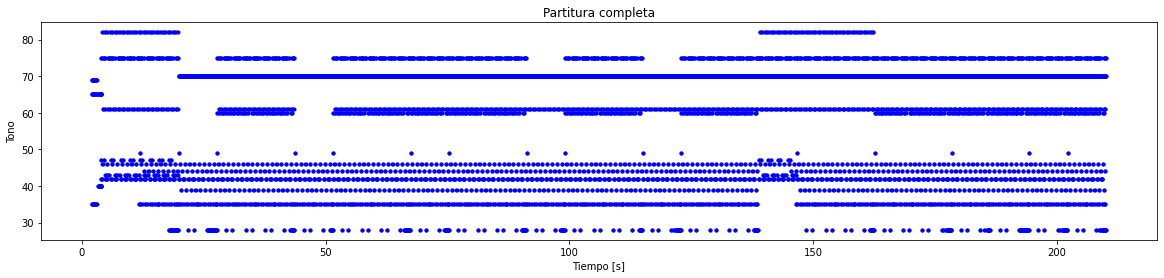

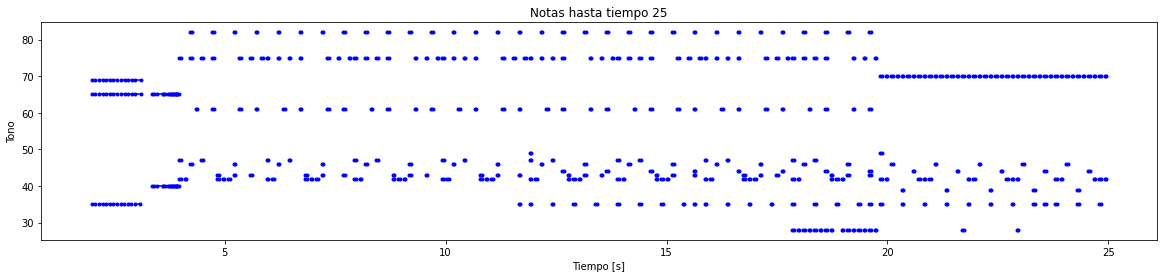

In [9]:
def plot_piano_roll(notes: pd.DataFrame, max_time: int = -1):
  if max_time == -1:
    title = f'Partitura completa'
  else:
    title = f'Notas hasta tiempo {max_time}'
    
  plt.figure(figsize=(20, 4))

  if max_time == -1:
    max_notes = notes
  else:
    max_notes = notes[notes['fin'] <= max_time]

  plot_pitch = np.stack([max_notes['tono'], max_notes['tono']], axis=0)
  plot_start_stop = np.stack([max_notes['inicio'], max_notes['fin']], axis=0)

  plt.plot(
    plot_start_stop[:, :], plot_pitch[:, :], color="b", marker=".")
  
  plt.xlabel('Tiempo [s]')
  plt.ylabel('Tono')
  _ = plt.title(title)

plot_piano_roll(raw_notes, -1)
plot_piano_roll(raw_notes, 25)

## 1.3 Procesado de datos [1.5 pts]

Ahora volvemos al artículo y aplicaremos el procesado de datos. Buscar dentro del fichero *data_processing_functions.py* la función que se encarga de llevar a cabo todo el procesado de datos y llamarla desde aquí

In [10]:
print(dpf.source_folder)
print(dpf.tempo_folder1)
dpf.do_all_steps()

data/original/
data/tempo/
changing Tempo
histogramming
data/tempo/


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


make song histo
shifting midi files
making note indexes
histogramming
data/shifted/tempo/
extracting chords
getting dictionary
converting chords to index sequences
done


1.3.1 ¿Qué hace la función *change_tempo_folder*?¿Qué bpm fija para las canciones?

Busca todos los ficheros en el árbol de directorios de origen, en nuestro caso `data/original`, y deja una copia procesada en la carpeta de destino, en nuestro caso `data/tempo`. 

Este proceso no replica la estructura de directorios sino que aplana el árbol dejando todos los ficheros encontrados en la carpeta de destino.

El proceso de copia crea un nuevo archivo MIDI a partir del original cambiando el tempo del mismo a "500000 microseconds per beat", que es el valor por defecto de MIDI:

> Unlike music, tempo in MIDI is not given as beats per minute, but rather in microseconds per beat. The default tempo is 500000 microseconds per beat, which is 120 beats per minute.

Fuente: [MIDI Tempo vs. BPM](https://mido.readthedocs.io/en/latest/midi_files.html)

Por tanto, el bpm asignado es 120, que es la equivalencia establecida anteriormente.

1.3.2 Una vez tenemos ejecutado el procesado de datos se habrán creado muchas carpetas y muchos ficheros nuevos en la actual carpeta ***data***. Ahora usaremos algunos de estos ficheros para construir la figura 2 del artículo usando los datos procesados. Crearemos dos funciones:
*   my_save_histo_oct_from_midi_folder
*   my_midi_to_histo_oct

basadas en las funciones ***save_histo_oct_from_midi_folder*** y ***midi_to_histo_oct*** que encontraréis en los ficheros ***midi_functions.py*** y ***data_processing_functions.py***. Ahora las modificaremos para que nos devuelvan datos para dos tipos de histogramas: uno igual a la figura 2 del artículo (apariciones VS pitch) y otro, usando el *histo_oct*, que serán datos para graficar *apariciones VS notas en cualquier octava*, es decir, el número de veces que aparece una nota (sin importar a que octava pertenezca) a lo largo de una canción.


*indicación: Es importante entender la estructura de las variables:*
*   pianoroll
*   histo_bar
*   histo_oct

*dentro de la funcion* ***midi_to_histo_oct***

In [11]:
#usa este vector como labels del segundo gráfico 
notas_en_una_octava = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

print(dpf.samples_per_bar)
print(dpf.octave)
print(dpf.fs)

8
12
4


        piano_roll : np.ndarray, shape=(128,times.shape[0])
            Piano roll of MIDI data, flattened across instruments.



In [12]:
def pianoroll_to_histo_bar(pianoroll, samples_per_bar):
    # Make histogramm for every samples_per_bar samples
    histo_bar = np.zeros((pianoroll.shape[0], int(pianoroll.shape[1]/samples_per_bar)))
    for i in range(0,pianoroll.shape[1]-samples_per_bar+1,samples_per_bar):
    #    print(i/samples_per_bar)
    #    print('i: ',i)
    #    print(i+samples_per_bar)
        histo_bar[:,int(i/samples_per_bar)] = np.sum(pianoroll[:,i:i+samples_per_bar], axis=1)
    return histo_bar

def histo_bar_to_histo_oct(histo_bar, octave):
    histo_oct = np.zeros((octave, histo_bar.shape[1]))
    for i in range(0, histo_bar.shape[0]-octave+1, octave):
#        print('i: ',i)
#        print(i+octave)
        histo_oct = np.add(histo_oct, histo_bar[i:i+octave])
    return histo_oct

In [13]:
def my_save_histo_oct_from_midi_folder(tempo_folder,histo_folder):
  print(tempo_folder)
  for path, subdirs, files in os.walk(tempo_folder):
    for name in files:
      _path = path.replace('\\', '/') + '/'
      _name = name.replace('\\', '/')
      target_path = histo_folder+_path[len(tempo_folder):]
      if not os.path.exists(target_path):
          os.makedirs(target_path)
      try:
          return my_midi_to_histo_oct(dpf.samples_per_bar,dpf.octave, dpf.fs, _name, _path, target_path)
      except (ValueError, EOFError, IndexError, OSError, KeyError, ZeroDivisionError) as e:
          exception_str = 'Unexpected error in ' + name  + ':\n', e, sys.exc_info()[0]
          print(exception_str)

def my_midi_to_histo_oct(samples_per_bar,octave, fs, name, path, histo_path):
  #print(path + name)
  pianoroll = mf.get_pianoroll(name, path, fs)
  histo_bar = mf.pianoroll_to_histo_bar(pianoroll, samples_per_bar)
  histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)
  pickle.dump(histo_oct,open(histo_path + name + '.pickle' , 'wb'))
  return histo_bar, histo_oct

histo_bar, histo_oct = my_save_histo_oct_from_midi_folder(
    dpf.tempo_folder1, dpf.histo_folder1)



data/tempo/


In [14]:
print(histo_bar.shape)

print(histo_bar[:,10])
print(histo_bar[2])

bar = np.sum(histo_bar, axis = 1)
print(bar.shape)
print(bar)

(128, 67)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 8. 0. 0. 0. 0. 0. 0. 4.
 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 6. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(128,)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2.   0.
  19.  42.  17.  89.   0.  49.   0.  70.  43.   2.  82.   5.  72.  40.
  17.  87.   0.  53.   0.  84.  41.   6. 106.   1.  68.  50.  29.  81.
   0.  86.   0.  58.  82.  15. 134.  27. 141.  59.  98. 161.  22. 183.
  12. 194.  88.   1.  90.   0.  

In [15]:
print(histo_oct.shape)
print(histo_oct)

d = np.array([[1, 2, 1, 2, 1],[3, 4, 3, 4, 3]])
print(d)
print(d.shape)

d2 = d.reshape(-1, 2)
print(d2.shape)
print(d2)
df = pd.DataFrame(d2, columns=['A', 'B'])
df.head(10)


(12, 67)
[[ 0.  0.  4.  5.  3. 10.  2.  1.  0.  0.  0.  0.  2.  0. 15. 12.  1.  4.
   3.  2.  0.  1.  1.  2.  0.  0.  0.  0.  0.  1. 19. 13.  1.  4.  4.  7.
   1.  5. 13.  5.  4.  5.  3.  9.  1.  2.  0.  0.  1.  0.  3.  1. 19. 13.
   1.  4.  4.  7.  1.  5. 13.  5.  4.  5.  3.  4.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  5.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  2.
   0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  5.  0.  0.  0.  0.  0.  2.  1.
   0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  2.  2. 19.  6.  6.  0.  0.  1.  3. 13.  7.  0.  3. 10.  1.
   0.  1. 14. 24. 12.  6.  0.  0.  0.  1. 21.  8.  0.  7. 10.  1.  0. 19.
  14.  1.  0. 23.  2.  2.  2. 19. 13.  7.  1.  0.  0.  1. 21.  8.  1.  7.
  11.  1.  0. 20. 14.  2.  0. 23.  1.  1.  2. 10.  8.]
 [ 0.  0.  0.  0.  1.  6.  0.  0.  0.  5.  0.  1.  0.  0.  0.  0.  1.  0.
   0.  0.  0.  0.  0.  0.  0.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0

,A,B
0,1,2
1,1,2
2,1,3
3,4,3
4,4,3


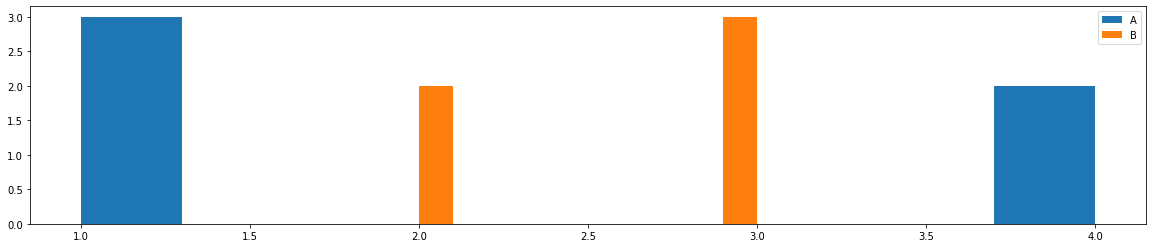

In [16]:
plt.figure(figsize=(20, 4))
plt.hist(df.A, label='A')
plt.hist(df.B, label='B')
plt.legend()

In [17]:
df = pd.DataFrame(histo_oct.reshape(-1,12), columns=notas_en_una_octava)
df.head(10)

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0.0,0.0,4.0,5.0,3.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0
1,2.0,0.0,15.0,12.0,1.0,4.0,3.0,2.0,0.0,1.0,1.0,2.0
2,0.0,0.0,0.0,0.0,0.0,1.0,19.0,13.0,1.0,4.0,4.0,7.0
3,1.0,5.0,13.0,5.0,4.0,5.0,3.0,9.0,1.0,2.0,0.0,0.0
4,1.0,0.0,3.0,1.0,19.0,13.0,1.0,4.0,4.0,7.0,1.0,5.0
5,13.0,5.0,4.0,5.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
8,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0


Vemos cómo aparecen las diferentes notas de la octava agrupando por tono.

Text(0, 0.5, 'Frecuencia')

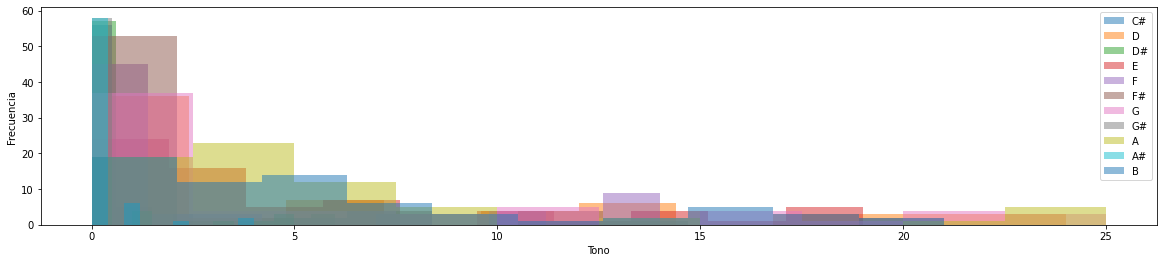

In [18]:
plt.figure(figsize=(20, 4))
for i in range(1,12):
  plt.hist(histo_oct[i], alpha=0.5, label=notas_en_una_octava[i])
plt.legend()
plt.xlabel('Tono')
plt.ylabel('Frecuencia')

Se ve en la gráfica que hay notas que parece que no aparecen en el gráfico dado que hay un número muy cercano en la posición cero al número total de datos (106).

Creamos ahora un gráfico eliminando el valor cero, para comprobarlo.

Text(0, 0.5, 'Frecuencia')

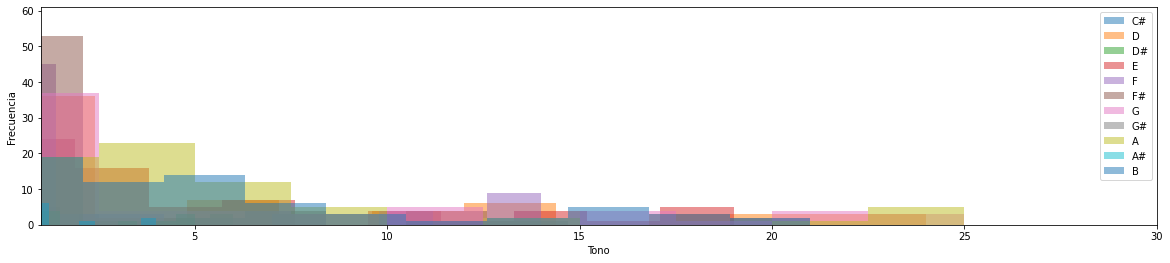

In [19]:
plt.figure(figsize=(20, 4))
for i in range(1,12):
  plt.hist(histo_oct[i], alpha=0.5, label=notas_en_una_octava[i])
plt.legend()
plt.xlim(1,30)
plt.xlabel('Tono')
plt.ylabel('Frecuencia')


In [20]:
def pitches_to_ocurrences(oct):
  return (oct > 0).astype(int)

def get_occurrences_in_octave(histo_oct):
  i = np.zeros(12)
  for oct in range(histo_oct.shape[1]):
    tmp = pitches_to_ocurrences(histo_oct[:,oct])
    i = i + tmp
  return i.reshape((1,12))

def xxx(histo_bar):
  occurrences_in_octaves = np.empty((1,12))
  octaves = histo_bar.shape[0]
  for octave in range(1, octaves):
    histo_oct = mf.histo_bar_to_histo_oct(histo_bar, 12)
    freq = get_occurrences_in_octave(histo_oct)
    occurrences_in_octaves = np.append(occurrences_in_octaves, freq, axis=0)

  print(occurrences_in_octaves.shape)
  df = pd.DataFrame(occurrences_in_octaves, columns=notas_en_una_octava)
  return df

def one_octave(histo_bar):
  octave = 12
  histo_oct = mf.histo_bar_to_histo_oct(histo_bar, octave)
  freq = get_occurrences_in_octave(histo_oct)
  df = pd.DataFrame(freq, columns=notas_en_una_octava)
  return df

df = one_octave(histo_bar)
df.head()

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,50.0,11.0,51.0,10.0,48.0,24.0,31.0,50.0,9.0,57.0,9.0,59.0


In [21]:
def aggregate_occurrences(histo_oct):
  n = np.zeros(12)
  for i in range(0,12):
    n[i] = np.sum(histo_oct[i])
  return n

freqs = aggregate_occurrences(histo_oct)
df = pd.DataFrame(freqs.reshape(1,12), columns=notas_en_una_octava)
df.head()


,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,258.0,24.0,414.0,33.0,334.0,201.0,169.0,424.0,26.0,379.0,16.0,414.0


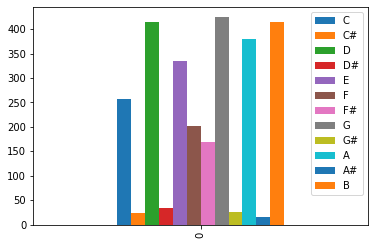

In [22]:
df.plot.bar()

(array([[128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [125.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [114.,   2.,   3.,   4.,   0.,   4.,   1.,   0.,   0.,   0.],
        [114.,   2.,   3.,   4.,   0.,   3.,   2.,   0.,   0.,   0.],
        [114.,   2.,   7.,   2.,   0.,   2.,   1.,   0.,   0.,   0.],
        [115.,   4.,   3.,   0.,   0.,   0.,   0.,   3.,   2.,   1.],
        [117.,   4.,   1.,   1.,   0.,   0.,   2.,   2.,   1.,   0.],
        [115.,   5.,   2.,   2.,   0.,   1.,   1.,   1.,   1.,   0.],
        [118.,   2.,   0.,   4.,   0.,   1.,   3.,   0.,   0.,   0.],
        [116.,   7.,   1.,   2.,   0.,   1.,   0.,   1.,   0.,   0.],
        [121.,   2.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   1.],
        [115.,   6.,   2.,   2.,   0.,   1.,   0.,   2.,   0.,   0.],
        [119.,   3.,   2.,   0.,   0.,   1.,   0.,   2.,   1.,   0.],
        [117.,   3.,   0.,   3.,   0.,   2.,   3.,   0.,   0.,   0.],
        [121.,   2.,

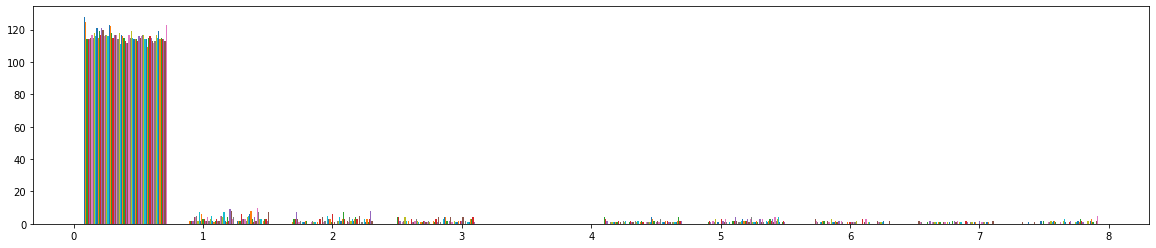

In [23]:
plt.figure(figsize=(20, 4))
plt.hist(histo_bar)

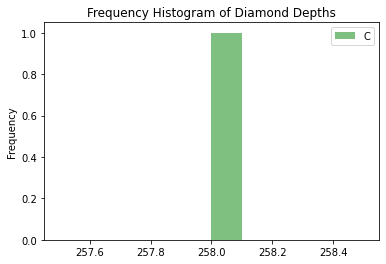

In [24]:
x1 = df.C

kwargs = dict(alpha=0.5)

plt.hist(x1, **kwargs, color='g', label='C')

plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
plt.legend();

In [25]:

plt.figure(figsize=(20, 4))

plt.hist(i.reshape(1,-1))
plt.legend()

AttributeError: ignored

<Figure size 1440x288 with 0 Axes>

1.3.3 Buscar en internet sobre las escalas musicales e indicar que escala es la que más aparece en todas las canciones analizadas. ¿Cuáles dirías que son las notas más importantes de la escala?

#2. LSTM para acordes [5 pts]

El siguiente paso en el artículo es el entrenamiento de una red LSTM para la generación de acordes. Esta parte la haremos con un data set más pequeño y lo compararemos con resultados de entrenamientos previos que os faciliaremos. Primero cargamos la librerias que necesitaremos

In [26]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation
from keras.layers import Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import keras.utils
from keras.utils import np_utils
from random import shuffle
import progressbar
import time

## 2.1 Carga de datos [0.5 pts]

2.1.1 En la carpeta ***data*** encontraréis un fichero llamado ***dataset.pkl*** que contiene 11338 canciones de train y 3780 de test. Usando *pickle* cargar los datos y luego separar 2000 para *train* y 500 canciones para *test* en las variables: 
*   train_set
*   test_set

crea además *train_set_size* y *test_set_size*

In [35]:
infile = open('./data/dataset.pkl','rb')
dataset = pickle.load(infile)
infile.close()

In [36]:
train_songs = dataset[0]
assert len(train_songs) == 11338

test_songs = dataset[1]
assert len(test_songs) == 3780

train_set = train_songs[0:2000]
train_set_size = len(train_set)
assert train_set_size == 2000

test_set = test_songs[0:500]
test_set_size = len(test_set)
assert test_set_size == 500

print(train_set_size, test_set_size)

2000 500


## 2.2 Modelo con una capa de ***Embedding*** [0.5 pts]

2.2.1 Ahora definiremos los parámetros de nuestra red LSTM usando los parámetros que dan en el artículo. El único cambio será en el tamaño de la red LSTM, en la que usaremos la mitad de la LSTM del artículo y número de epochs que usaremos 10 en nuestro caso

In [29]:
batch_size = 1
step_size = 1
epochs = 10

#completar
lstm_size = 128
learning_rate = 10**-5
optimizer = Adam(lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


El siguiente código es para mantener la estructura de carpetas que usan en el artículo ya que hay mucho código que depende de esta estructura:

In [30]:
##--------NO TOCAR-------------------------------------------------------
base_path = 'models/chords/'
model_filetype = '.pickle'

shuffle_train_set = True
bidirectional = False

#Create model dir
fd = {'shifted': shifted, 'lr': learning_rate, 'emdim': chord_embedding_dim, 'opt': optimizer,
'bi': bidirectional, 'lstms': lstm_size, 'trainsize': train_set_size, 'testsize': test_set_size, 'samples_per_bar': samples_per_bar}
t = str(np.random.randint(1000,9999))
model_name = t+ '-Shifted_%(shifted)s_Lr_%(lr)s_EmDim_%(emdim)s_opt_%(opt)s_bi_%(bi)s_lstmsize_%(lstms)s_trainsize_%(trainsize)s_testsize_%(testsize)s_samples_per_bar%(samples_per_bar)s' % fd
model_path = base_path + model_name + '/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
##--------NO TOCAR-------------------------------------------------------


2.2.2 Finalmente definimos y compilamos la red con una capa de Embedding antes de la LSTM. Para este paso, acceder al código original del artículo y buscar en que fichero se entrena la LSTM copiar la estructura eliminando código que no es de nuestro interés

In [31]:
model = Sequential()
model.add(Embedding(num_chords, chord_embedding_dim, input_length=step_size, name="embedding", batch_input_shape=(batch_size,step_size)))
# model.add(Embedding(num_chords, chord_embedding_dim, input_length=step_size))

# if bidirectional: model.add(Bidirectional(LSTM(lstm_size, stateful=True)))
# else: model.add(LSTM(lstm_size, stateful=True))
model.add(LSTM(lstm_size, stateful=True))
model.add(Dense(num_chords))
model.add(Activation('softmax'))

model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (1, 1, 10)                500       
                                                                 
 lstm (LSTM)                 (1, 128)                  71168     
                                                                 
 dense (Dense)               (1, 50)                   6450      
                                                                 
 activation (Activation)     (1, 50)                   0         
                                                                 
Total params: 78,118
Trainable params: 78,118
Non-trainable params: 0
_________________________________________________________________


In [32]:
loss = 'categorical_crossentropy'
print("compiling model")
model.compile(optimizer, loss)

compiling model


## 2.3 Entrenamiento [2 pts]

2.3.1 Siguiendo el código orginal del artículo donde se define la arquitectura de la LSTM para los acordes hay 3 funciones más:
*   test()
*   train()
*   save_params()

que nos serán de ayuda para el entrenamiento, testeo y para guardar los datos sobre el modelo entrenado. Guardaremos el valor de la ***loss*** tanto para test como para train cada 500 canciones, por lo que tendremos más de un punto por epoch. Modifica, si es necesario, las funciones *test()* y *train()* para que los ficheros de *total_test* y *total_train* dejen constancia de la epoch a la que pertenecen, esto te ayudará al graficar los datos más adelante.

Añade, antes de cada función una cabecera explicando brevemente lo que ésta hace.

---

*nota: comprueba que has definido todas las variables necesarias para que las* *funciones no den error en mitad del entrenamiento. Comienza usando menos datos* *para agilizar el proceso y una vez funcione todo usa el set completo*

In [37]:
epoch_array=[]
total_test_loss_array = [] 
total_train_loss_array = []
total_test_loss = 0
show_plot = False
save_plot = False
test_step = 500
verbose = False
save_step = 1

# Vars for testing algorithm
#train_set = train_songs[0:20]
#train_set_size = len(train_set)
#test_set = test_songs[0:5]
#test_set_size = len(test_set)
#test_step = 5

#crea aquí las funciones test(), train() y save_params()
def test():
    print('\nTesting:')
    total_test_loss = 0

    bar = progressbar.ProgressBar(maxval=test_set_size, redirect_stdout=False)
    for i, test_song in enumerate(test_set):
        X_test = test_song[:-1]
        X_test = np.array(X_test)
        Y_test = np_utils.to_categorical(test_song[1:], num_classes=num_chords)
        loss = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
        model.reset_states()
        total_test_loss += loss
        bar.update(i+1)
    total_test_loss_array.append(total_test_loss/test_set_size)
    print('\nTotal test loss: ', total_test_loss/test_set_size)
    print('-'*50)
    plt.plot(total_test_loss_array, 'b-', label='test loss')
    plt.plot(total_train_loss_array, 'r-', label='train loss')
#    plt.legend()
    plt.ylabel(model_path)
#    plt.axis([0, 50, 3, 5])
    plt.grid()
    if show_plot: plt.show()
    if save_plot: plt.savefig(model_path+'plot.png')
    pickle.dump(total_test_loss_array,open(model_path+'total_test_loss_array.pickle', 'wb'))
    pickle.dump(total_train_loss_array,open(model_path+'total_train_loss_array.pickle', 'wb'))
    pickle.dump(epoch_array,open(model_path+'epoch_array.pickle', 'wb'))

def train():
    print('training model...')
    total_train_loss = 0
    for e in range(1, epochs+1):
        print('Epoch ', e, 'of ', epochs, 'Epochs\nTraining:')
        if shuffle_train_set:
            shuffle(train_set)
        bar = progressbar.ProgressBar(maxval=train_set_size)
        for i, song in enumerate(train_set):
            # bar.start()
            X = song[:-1]
            X = np.array(X)
            Y = np_utils.to_categorical(song[1:], num_classes=num_chords)
            hist = model.fit(X, Y, batch_size=batch_size, shuffle=False, verbose=verbose)
            model.reset_states()
            bar.update(i+1)
#            print(hist.history)
            total_train_loss += hist.history['loss'][0]
            if (i+1)%test_step is 0:
                total_train_loss = total_train_loss/test_step
                total_train_loss_array.append(total_train_loss)
                epoch_array.append(e)
                test()
                total_train_loss = 0
    
        if e%save_step is 0:
            print('saving model')
            model_save_path = model_path + 'model_' + 'Epoch' + str(e) + '_' + str(i+1) + model_filetype
            model.save(model_save_path)

def save_params():
    with open(model_path + 'params.txt', "w") as text_file:
        text_file.write("epochs: %s" % epochs + '\n')
        text_file.write("train_set_size: %s" % train_set_size + '\n')
        text_file.write("test_set_size: %s" % test_set_size + '\n')
        text_file.write("lstm_size: %s" % lstm_size + '\n')
        text_file.write("embedding_dim: %s" % chord_embedding_dim + '\n')
        text_file.write("learning_rate: %s" % learning_rate + '\n')
        #text_file.write("save_step: %s" % save_step + '\n')
        text_file.write("shuffle_train_set: %s" % shuffle_train_set + '\n')
        text_file.write("test_step: %s" % test_step + '\n')
        text_file.write("bidirectional: %s" % bidirectional + '\n')
        text_file.write("num_chords: %s" % num_chords + '\n')
        text_file.write("chord_n: %s" % chord_n + '\n')

2.3.2 Responde las siguientes preguntas:
*  ¿Qué representa cada elemento de *X* en la función de *train()*?
*  ¿Qué se está usando como *label* para cada elemento de *X*? 
*  Justifica el uso de *categorical_crossentropy* como función de loss
*  ¿Qué crees que está aprendiendo la red?




 



*   Cada elemento X en la función de *train()* representa un acorde
*   Para cada elemento de X, se está usando como *label* el identificador del acorde, de los que se han escogido los 50 más repetidos y al resto se le asigna una etiqueta de *unkwown*
*   Nos encontramos ante un problema de clasificación donde se pretende predecir qué tipo de acorde será el siguiente de la partitura, por tanto, la función de pérdida debe ser *categorica_crossentropy*. 
*   La red está aprendiendo a predecir cuáles serán los siguientes acordes a tocar.



2.3.3 Entrena la red usando las funciones anteriores

In [ ]:
save_params()
train()

training model...
Epoch  1 of  10 Epochs
Training:


 25% (500 of 2000) |#####                | Elapsed Time: 0:03:47 ETA:   0:09:53


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:44 ETA:  00:00:00


Total test loss:  3.180297596693039
--------------------------------------------------


 50% (1000 of 2000) |##########          | Elapsed Time: 0:10:24 ETA:   0:08:31


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:42 ETA:  00:00:00


Total test loss:  3.123581279039383
--------------------------------------------------


 75% (1500 of 2000) |###############     | Elapsed Time: 0:16:59 ETA:   0:04:45


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:41 ETA:  00:00:00


Total test loss:  3.086948522090912
--------------------------------------------------


100% (2000 of 2000) |####################| Elapsed Time: 0:23:29 ETA:  00:00:00


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:45 ETA:  00:00:00


Total test loss:  3.074198194026947
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/6588-Shifted_True_Lr_1e-05_EmDim_10_opt_<keras.optimizer_v2.adam.Adam object at 0x7fb5f73ae450>_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch1_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/6588-Shifted_True_Lr_1e-05_EmDim_10_opt_<keras.optimizer_v2.adam.Adam object at 0x7fb5f73ae450>_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch1_2000.pickle/assets


Epoch  2 of  10 Epochs
Training:


 25% (500 of 2000) |#####                | Elapsed Time: 0:03:46 ETA:   0:09:15


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:43 ETA:  00:00:00


Total test loss:  3.0548394222259523
--------------------------------------------------


 50% (1000 of 2000) |##########          | Elapsed Time: 0:10:21 ETA:   0:08:49


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:45 ETA:  00:00:00


Total test loss:  3.036005690097809
--------------------------------------------------


 75% (1500 of 2000) |###############     | Elapsed Time: 0:16:57 ETA:   0:04:10


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:41 ETA:  00:00:00


Total test loss:  3.0331657972335817
--------------------------------------------------


100% (2000 of 2000) |####################| Elapsed Time: 0:23:34 ETA:  00:00:00


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:41 ETA:  00:00:00


Total test loss:  3.021654367208481
--------------------------------------------------
saving model


INFO:tensorflow:Assets written to: models/chords/6588-Shifted_True_Lr_1e-05_EmDim_10_opt_<keras.optimizer_v2.adam.Adam object at 0x7fb5f73ae450>_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch2_2000.pickle/assets


INFO:tensorflow:Assets written to: models/chords/6588-Shifted_True_Lr_1e-05_EmDim_10_opt_<keras.optimizer_v2.adam.Adam object at 0x7fb5f73ae450>_bi_False_lstmsize_128_trainsize_2000_testsize_500_samples_per_bar8/model_Epoch2_2000.pickle/assets


Epoch  3 of  10 Epochs
Training:


 25% (500 of 2000) |#####                | Elapsed Time: 0:03:48 ETA:   0:10:44


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:44 ETA:  00:00:00


Total test loss:  3.0207109572887423
--------------------------------------------------


 50% (1000 of 2000) |##########          | Elapsed Time: 0:10:23 ETA:   0:10:04


Testing:


100% (500 of 500) |######################| Elapsed Time: 0:02:44 ETA:  00:00:00


Total test loss:  3.0159135105609893
--------------------------------------------------


 70% (1410 of 2000) |##############      | Elapsed Time: 0:16:14 ETA:   0:05:52

##2.4 Comparación de modelos [2 pts]

En este último paso compararemos diferentes modelos. En la carpeta *models/chords* encontrarás los datos (en un formato similar al generado anteriormente) del entrenamiento de modelos similares con otros parámetros:

1.   carpeta: 2717-Shifted_True_...
2.   carpeta: 5102-Shifted_True_...



2.4.1 Compara los 3 modelos: grafica las funciones de loss para train y test de cada modelo.

*   Indica los parámetros de cada uno de los 3 modelos (el que habéis entrenado y los 2 que os hemos dado)
*   ¿Qué set de parámetros ha dado la mejor performance?
*   ¿Se aprecia overfitting en alguno de los modelos? Justifica tu respuesta

# 3 Análisis de la capa de embedding [2 pts]

En esta sección recrearemos la figura 8 del artículo con la red que hemos entrenado y la que mejor performance nos ha dado en la comparación. 

In [ ]:
from keras.models import load_model
import keras
from keras import backend as K

## 3.1 Carga de modelos entrenados y generación de embeddings [1 pts]

3.1.1 Utiliza el *load_model* de **keras** para cargar:
*   el modelo que hemos entrenado: *my_model*
*   el modelo con mejor performance: *bp_model*


3.1.2 Ahora crearemos, para cada modelo, un nuevo modelo para los embedding. Para hacer esto, deberás crear un nuevo modelo cuya entrada sea igual a la entrada de los modelos originales y la salida sea el layer "embedding". Esto lo puedes hacer usando la función *get_layer()* del modelo.


3.1.3 El modelo de embedding recibe un acorde y devuelve un vector de 10 dimensiones con el embedding para cada acorde. Calcula estos vectores con cada uno de los modelos de embedding

3.1.4 Aplica un squeeze para eliminar los ejes de dimensión 1. El resultado de este squeeze debería ser (50,10)

## 3.2 Análisis PCA [1 pts]


Para acabar con nuestro análisis de los embeddings, vamos a realizar un proceso de PCA para reducir las dimensiones de los vectores resultantes y poder graficarlos en 2D.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

3.2.1 Escalar los vectores y aplicar PCA para reducir a 2 las dimensiones

3.2.2 Grafica para ambos embeddings los vectores en un scatterplot. Añadele anotaciones con las notas del acorde y comenta el resultado: ¿Observas el efecto word2vect en las gráficas?

Usa esta función para obtener un índice para los acordes y sus notas

In [ ]:
def get_chord_dict():
    chord_to_index = pickle.load(open(dict_path + chord_dict_name, 'rb'))
    index_to_chord = pickle.load(open(dict_path + index_dict_name, 'rb'))
    return chord_to_index, index_to_chord

chord_to_index, idx_2_chord = get_chord_dict()

3.2.3 Crea una función para calcular todas las distancias entre los primero 20 acordes. Luego haz una lista con las 10 distancias mínimas para ambos modelos. ¿Están relacionados estos acordes con distancias mínimas?

# 4. Rueda de 5tas (Bonus Track) [0.5 pts]

En este bonus track, y usando lo mismo que has usado para los apartados anteriores, podrás dibujar la rueda de quintas con datos entrenados sobre la misma base de datos, pero no hacer el shifteo de los acordes.

Usa los datos que encontrarás en la carpeta *models/chords/9671-Shifted_False...* para repetir el proceso del análisis de PCA

Una vez tienes los vectores, llama a las siguientes funciones para dibujar la rueda de quintas

In [ ]:
def get_chord_dict_no_shifted():
    chord_to_index = pickle.load(open('data/chord_dict.pickle', 'rb'))
    index_to_chord = pickle.load(open('data/index_dict.pickle', 'rb'))
    return chord_to_index, index_to_chord

chord_to_index_, idx_2_chord_ = get_chord_dict_no_shifted()

In [ ]:
ddd={tuple((0,4,7)):'C',
tuple((1,5,8)):'C#',
tuple((2,6,9)):'D',
tuple((3,7,10)):'D#',
tuple((4,8,11)):'E',
tuple((0,5,9)):'F',
tuple((1,6,10)):'F#',
tuple((2,7,11)):'G',
tuple((0,3,8)):'G#',
tuple((1,4,9)):'A',
tuple((2,5,10)):'A#',
tuple((3,6,11)):'B'}


def plot_5th_circle(X_chords_2d):
  
  fig, ax = plt.subplots()
  fig.set_size_inches(8, 6)

  plt.tick_params(labelsize=12)
  
  style = dict(size=12, color='black')

  for i in range(0,len(idx_2_chord_)):
    try:
      ax.text(-X_chords_2d[i,0]-0.32,X_chords_2d[i,1]+0.11, ddd[idx_2_chord_[i]],**style)
      ax.scatter(-X_chords_2d[i,0],X_chords_2d[i,1], c="blue", marker="*")
      
    except:
      pass

  plt.show()

In [ ]:
plot_5th_circle(my_embedd_pca) #pasa los vectores luego del análisis de PCA